## Aula 02 - Exercícios

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

### Importar base de dados

In [3]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

ModuleNotFoundError: No module named 'wget'

In [2]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

FileNotFoundError: [Errno 2] No such file or directory: './dataset/movies_sample.csv'

### Mapeamento de ids

In [4]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title


### Divisão da base em treino e teste

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

**Exercício 01**: Considere o modelo SVD++ visto no final da aula de FC - parte 2. Uma das extensões desse modelo em relação ao SVD otimizado é que ele considera a lista de itens que o usuário forneceu feedback implícito (por exemplo, antes de fornecer uma nota a um filme, ele "navegou" por outros filmes, sem dar nota). Podemos simular essa navegação com a base de dados fornecida considerando como feedback implícito de cada usuário o conjunto de itens que ele avaliou, porém descartando as notas.

***a)*** Implemente a função de treinamento do modelo SVD++.

This was my first first approach. It is correct, however, it was too slow and prone to overflows.

In [6]:
def train_svdpp(train, n_factors, lr=0.05, reg=0.02, miter=10):
    # Calculate the global mean rating (μ)
    mean = train['rating'].mean()
    
    # Number of unique users and items in the dataset
    n_users = df['userId'].max() + 1
    n_items = df['movieId'].max() + 1

    # Initialize bias terms and latent factor matrices
    bu = np.zeros(n_users)  # User biases
    bi = np.zeros(n_items)  # Item biases
    p = np.random.normal(0.1, 0.1, (n_users, n_factors))  # User latent factors
    q = np.random.normal(0.1, 0.1, (n_items, n_factors))  # Item latent factors
    y = np.random.normal(0.1, 0.1, (n_items, n_factors))  # Implicit feedback latent factors

    # Implicit feedback: Create a dictionary mapping each user to the set of items they have interacted with
    N_u = {u: set(train[train['userId'] == u]['movieId']) for u in train['userId'].unique()}

    # List to store the RMSE for each iteration
    errors = []

    # Precomputing useful values
    n = np.array([len(N_u[u]) for u in range(n_users)], dtype=np.float64) ** (-0.5)
    
    # Training the model: Loop over factors and iterations
    for f in range(n_factors):
        for t in range(miter):
            err = 0  # Initialize error for this iteration

            # Loop through each user-item-rating triplet in the training data
            for index, row in train.iterrows():
                u = row['userId']  # User ID
                i = row['movieId']  # Item ID
                r_ui = row['rating']  # Actual rating

                # Calculate the prediction (predicted rating)
                bias = bu[u] + bi[i]  # Sum of user and item biases
                n = len(N_u[u]) ** (-0.5)  # Normalization factor for implicit feedback
                sum_y = np.sum(y[list(N_u[u])], axis=0)  # Sum of implicit feedback factors
                factor = np.dot(q[i], (p[u] + n * sum_y))  # Dot product of item and user latent factors with implicit feedback
                pred = mean + bias + factor  # Final prediction

                # Calculate the prediction error
                e_ui = r_ui - pred
                err += e_ui ** 2  # Accumulate squared error for RMSE calculation

                # Update user and item biases
                bu[u] = bu[u] + lr * (e_ui - reg * bu[u])
                bi[i] = bi[i] + lr * (e_ui - reg * bi[i])

                # Update user and item latent factors
                temp_uf = p[u][f]  # Temporary storage for the current user factor
                p[u][f] = p[u][f] + lr * (e_ui * q[i][f] - reg * p[u][f])
                q[i][f] = q[i][f] + lr * (e_ui * (temp_uf + n * sum_y[f]) - reg * q[i][f])

                # Update the implicit feedback factors for all items user u has interacted with
                for j in N_u[u]:
                    y[j][f] = y[j][f] + lr * (e_ui * n * q[i][f] - reg * y[j][f])

            # Calculate RMSE for this iteration and append to the errors list
            errors.append(np.sqrt(err / len(train)))

    return mean, bu, bi, p, q, y, N_u, errors


Second approach. After many tests and optimizations, i made it way faster using batch computing with numpy. Fixed the overflow with a gradiant clip and improved learning speed with a learning rate with momentum.

In [7]:
def train_svdpp_optm(train, n_factors, lr=0.05, reg=0.02, miter=10, clip_value=1.0, inertial_factor=1.05, decay_factor=0.5):
    """
    Optimized training of an SVD++ model using vectorized operations with NumPy's advanced indexing,
    gradient clipping, and inertial learning rate adjustment.
    """
    # Calculate the global mean rating (μ)
    mean = train['rating'].mean()
    
    # Number of unique users and items in the dataset
    n_users = train['userId'].max() + 1
    n_items = train['movieId'].max() + 1

    # Initialize bias terms and latent factor matrices
    bu = np.zeros(n_users)  # User biases
    bi = np.zeros(n_items)  # Item biases
    p = np.random.normal(0.1, 0.1, (n_users, n_factors))  # User latent factors
    q = np.random.normal(0.1, 0.1, (n_items, n_factors))  # Item latent factors
    y = np.random.normal(0.1, 0.1, (n_items, n_factors))  # Implicit feedback latent factors

    # Implicit feedback: Create a dictionary mapping each user to the set of items they have interacted with
    f = lambda u: np.array(train[train['userId'] == u]['movieId'].unique())
    N_u = {u: f(u) for u in train['userId'].unique()}

    # List to store the RMSE for each iteration
    errors = []
    
    # Precomputing useful values (normalization factor for each user)
    n = np.zeros(n_users)
    n[list(N_u.keys())] = np.array([len(s) for s in N_u.values()], dtype=np.float64) ** (-0.5)
    
    print("Finished precomputing values")
    
    # Training the model: Loop over factors and iterations
    for t in range(miter):
        err = 0  # Initialize error for this iteration

        # Loop through each user-item-rating triplet in the training data
        for index, row in train.iterrows():
            u = row['userId']  # User ID
            i = row['movieId']  # Item ID
            r_ui = row['rating']  # Actual rating

            # Sum of implicit feedback factors
            sum_y = np.sum(y[N_u[u]], axis=0)

            # Calculate the prediction (predicted rating)
            bias = bu[u] + bi[i]
            product = np.dot(q[i], (p[u] + n[u] * sum_y))
            pred = mean + bias + product  # Final prediction

            # Calculate the prediction error
            e_ui = r_ui - pred
            err += e_ui ** 2

            # Gradient clipping before updates
            bu_grad = lr * (e_ui - reg * bu[u])
            bi_grad = lr * (e_ui - reg * bi[i])
            p_grad = lr * (e_ui * q[i] - reg * p[u])
            q_grad = lr * (e_ui * (p[u] + n[u] * sum_y) - reg * q[i])
            y_grad = lr * (e_ui * n[u] * q[i] - reg * y[N_u[u]])

            # Clip gradients
            bu_grad = np.clip(bu_grad, -clip_value, clip_value)
            bi_grad = np.clip(bi_grad, -clip_value, clip_value)
            p_grad = np.clip(p_grad, -clip_value, clip_value)
            q_grad = np.clip(q_grad, -clip_value, clip_value)
            y_grad = np.clip(y_grad, -clip_value, clip_value)

            # Update user and item biases
            bu[u] += bu_grad
            bi[i] += bi_grad

            # Update user and item latent factors
            p[u] += p_grad
            q[i] += q_grad

            # Update the implicit feedback factors for all items user u has interacted with
            y[N_u[u]] += y_grad

        # Calculate RMSE for this iteration and append to the errors list
        rmse = np.sqrt(err / len(train))
        print(f'Iteration {t+1}: RMSE = {rmse}')
        errors.append(rmse)

        # Adjust learning rate based on RMSE improvement
        if t > 0:
            lr *= decay_factor
            # lr *= inertial_factor if errors[-1] < errors[-2] else decay_factor

    return {
        'mean': mean,
        'bu': bu,
        'bi': bi,
        'p': p,
        'q': q,
        'y': y,
        'N_u': N_u,
        'n': n,
        'errors': errors
    }


In [8]:
def svdpp_save(svdpp, path):
    # Save the components using np.savez, including the converted N_u keys and values
    np.savez(
        path, 
        mean=svdpp['mean'], 
        bu=svdpp['bu'], 
        bi=svdpp['bi'], 
        p=svdpp['p'], 
        q=svdpp['q'], 
        y=svdpp['y'], 
        N_u=svdpp['N_u'],
        n=svdpp['n'], 
        errors=svdpp['errors']
    )

    
def svdpp_load(path):
    data = np.load(path, allow_pickle=True)
    
    # Convert the dictionary of arrays to a dictionary of numpy arrays
    N_u_dict = data['N_u'].item()  # Extract the dictionary object from the numpy array
    N_u_converted = {k: np.array(v) for k, v in N_u_dict.items()}  # Convert each list to a numpy array

    return {
        'mean': data['mean'],
        'bu': data['bu'],
        'bi': data['bi'],
        'p': data['p'],
        'q': data['q'],
        'y': data['y'],
        'N_u': N_u_converted,  # Use the converted dictionary here
        'n': data['n'],
        'errors': data['errors']
    }


In [9]:
# Train the SVD++ model with optimized training
svdpp = train_svdpp_optm(
    train, 
    n_factors=10, 
    lr=0.05, 
    reg=0.02, 
    miter=20, 
    clip_value=5.0, 
    inertial_factor=1.05, 
    decay_factor=0.6
)

# svdpp = svdpp_load('svdpp_model.npz')

svdpp

Finished precomputing values
Iteration 1: RMSE = 0.8795466899685959
Iteration 2: RMSE = 0.8144562758950982
Iteration 3: RMSE = 0.764744119248506
Iteration 4: RMSE = 0.7309672242953488
Iteration 5: RMSE = 0.7079660417729533
Iteration 6: RMSE = 0.6927811083201019
Iteration 7: RMSE = 0.6831172305404295
Iteration 8: RMSE = 0.6770917806956941
Iteration 9: RMSE = 0.6733555728342543
Iteration 10: RMSE = 0.671037453742045
Iteration 11: RMSE = 0.6696015243134327
Iteration 12: RMSE = 0.6687165608305511
Iteration 13: RMSE = 0.6681740789682232
Iteration 14: RMSE = 0.6678425378639237
Iteration 15: RMSE = 0.6676397983818846
Iteration 16: RMSE = 0.6675161734430164
Iteration 17: RMSE = 0.6674412630269995
Iteration 18: RMSE = 0.6673960710388573
Iteration 19: RMSE = 0.6673688729137144
Iteration 20: RMSE = 0.6673525254209774


{'mean': 3.4297948798657014,
 'bu': array([ 0.76462629,  0.22827151, -0.26357308, ..., -0.03757823,
         0.87973216,  0.42899307]),
 'bi': array([ 0.10084778,  0.04308488, -0.34421633,  0.1091565 , -0.00412847,
         0.07568061,  0.21949036, -0.46110258, -0.05572542, -0.23818087,
         0.25771059, -0.67136704,  0.53007355, -0.09238601,  0.02394828,
        -0.27839563, -0.21325118, -0.07419341,  0.37810602,  0.40202982,
        -0.18513937, -0.02541839, -0.02070017,  0.13299616, -0.31704611,
        -0.2036833 ,  0.17330289,  0.03786336, -0.19809256, -0.11454016,
         0.14683866, -0.05208607,  0.07663552,  0.42530104,  0.27698373,
         0.03706399, -0.01332446, -0.31015805,  0.32162863, -0.01752675,
         0.24462118,  0.10737503, -0.08651914, -0.08329194,  0.00333041,
         0.17123391,  0.18002037, -0.30175666, -0.640201  , -0.10270007,
        -0.33287856, -1.26767973, -0.07021576, -0.30828514, -0.12750815,
        -0.76239545, -0.68445986, -0.31155227, -0.63012

In [10]:
# # Save the trained SVD++ model
# svdpp_save(svdpp, 'svdpp_model.npz')

***b)*** Plote a curva de aprendizado de seu modelo.

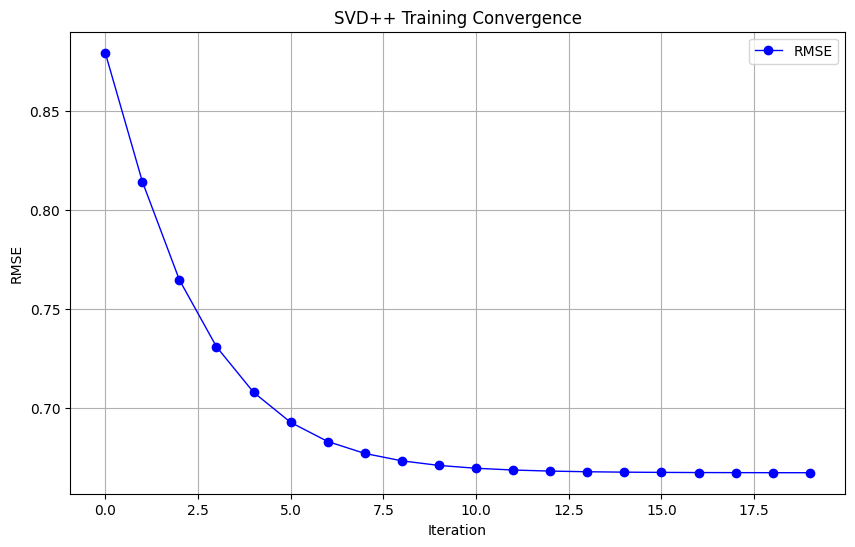

In [11]:
def plot_errors(errors, title="Error during training"):
    plt.figure(figsize=(10, 6))
    plt.plot(errors, label='RMSE', color='blue', marker='o', linestyle='-', linewidth=1)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_errors(svdpp['errors'], 'SVD++ Training Convergence')

***c)*** Implemente a função de predição do modelo SVD++, comparando algumas notas preditas com as notas reais do conjunto de teste.

In [12]:
def svdpp_predict(user, item, svdpp):
    """
    Predict the rating of a user for a specific item using an SVD++ model.
    """
    # Check if the user has interacted with any items
    if user not in svdpp['N_u'].keys():
        return svdpp['mean']

    # Calculate the prediction (predicted rating)
    bias = svdpp['bu'][user] + svdpp['bi'][item]
    sum_y = np.sum(svdpp['y'][svdpp['N_u'][user]], axis=0)
    factor = np.dot(svdpp['q'][item], (svdpp['p'][user] + svdpp['n'][user] * sum_y))
    pred = svdpp['mean'] + bias + factor

    return pred

def svdpp_predict_many(test, svdpp):
    """
    Predict the ratings of multiple users for multiple items using an SVD++ model.
    """
    return np.array([svdpp_predict(row['userId'], row['movieId'], svdpp) for _, row in test.iterrows()])

def test_svdpp(test, svdpp):
    """
    Evaluate the SVD++ model on a test set and calculate the RMSE.
    """
    
    # Calculate the prediction for each user-item pair in the test set
    preds = svdpp_predict_many(test, svdpp)

    # Calculate the RMSE
    rmse = np.sqrt(np.mean((test['rating'] - preds) ** 2))

    return rmse

In [13]:
test_svdpp(test, svdpp)

0.8309349367907791

**Exercício 02**: Utilizando o código do NCF visto na aula, compare o desempenho entre as instâncias GMF, MLP e NeuMF nesta base de dados (ml-20m-compact).

##### Models

In [14]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, stand_alone=True):
        nn.Module.__init__(self)  # Directly call nn.Module's constructor
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
                 
        if stand_alone:
            self.output = nn.Linear(embedding_dim, 1)
            self.sigmoid = nn.Sigmoid()
        
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
        self.stand_alone = stand_alone

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        output = user_emb * item_emb  # Produto de Hadamard
        
        if self.stand_alone:
            output = self.sigmoid(self.output(output))
        
        return output


class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_layers=[64, 32, 16, 8]):
        nn.Module.__init__(self)  # Directly call nn.Module's constructor
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
        layers = []
        input_size = embedding_dim * 2
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        
        self.mlp_layers = nn.Sequential(*layers)
    
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        mlp_input = torch.cat([user_emb, item_emb], dim=-1)
        mlp_output = self.mlp_layers(mlp_input)
        return mlp_output


class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_layers=[64, 32, 16, 8], pretrained_gmf=None, pretrained_mlp=None):
        nn.Module.__init__(self)  # Initialize nn.Module
        GMF.__init__(self, num_users, num_items, embedding_dim, stand_alone=False)
        MLP.__init__(self, num_users, num_items, embedding_dim, hidden_layers)
        
        # Final layer to combine GMF and MLP outputs
        combined_input_size = embedding_dim + hidden_layers[-1]
        self.output_layer = nn.Linear(combined_input_size, 1)
        self.sigmoid = nn.Sigmoid()
        
        # Load pretrained weights if provided
        if pretrained_gmf:
            self.user_embedding.weight.data.copy_(pretrained_gmf.user_embedding.weight)
            self.item_embedding.weight.data.copy_(pretrained_gmf.item_embedding.weight)
        if pretrained_mlp:
            self.user_embedding.weight.data.copy_(pretrained_mlp.user_embedding.weight)
            self.item_embedding.weight.data.copy_(pretrained_mlp.item_embedding.weight)
            self.mlp_layers.load_state_dict(pretrained_mlp.mlp_layers.state_dict())
    
    def forward(self, user, item):
        # GMF forward pass
        gmf_output = GMF.forward(self, user, item)
        
        # MLP forward pass
        mlp_output = MLP.forward(self, user, item)
        
        # Concatenate GMF and MLP outputs
        combined_output = torch.cat([gmf_output, mlp_output], dim=-1)
        
        # Pass through final output layer and apply sigmoid
        output = self.sigmoid(self.output_layer(combined_output))
        
        return output


##### Data

In [15]:
# Initialize the scaler
device = torch.device('cpu')
scaler = MinMaxScaler(feature_range=(0.0, 1.0))

# Fit the scaler on the training ratings and transform both train and test ratings
train_ratings_norm = scaler.fit_transform(train['rating'].values.reshape(-1, 1))
test_ratings_norm = scaler.transform(test['rating'].values.reshape(-1, 1))

# Now, convert the dataset to torch tensors
train_users = torch.tensor(train['userId'].values, dtype=torch.long)
train_items = torch.tensor(train['movieId'].values, dtype=torch.long)
train_ratings = torch.tensor(train_ratings_norm, dtype=torch.float32).squeeze()  # Normalize train ratings

test_users = torch.tensor(test['userId'].values, dtype=torch.long)
test_items = torch.tensor(test['movieId'].values, dtype=torch.long)
test_ratings = torch.tensor(test_ratings_norm, dtype=torch.float32).squeeze()  # Normalize test ratings

# Creating the data loaders
train_dataset = TensorDataset(train_users, train_items, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = TensorDataset(test_users, test_items, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [16]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0.0, 1.0))

# Fit the scaler on the training ratings and transform both train and test ratings
train_ratings_norm = scaler.fit_transform(train['rating'].values.reshape(-1, 1))
test_ratings_norm = scaler.transform(test['rating'].values.reshape(-1, 1))

# Now, convert the dataset to torch tensors (still on CPU)
train_users = torch.tensor(train['userId'].values, dtype=torch.long)
train_items = torch.tensor(train['movieId'].values, dtype=torch.long)
train_ratings = torch.tensor(train_ratings_norm, dtype=torch.float32).squeeze()  # Normalize train ratings

test_users = torch.tensor(test['userId'].values, dtype=torch.long)
test_items = torch.tensor(test['movieId'].values, dtype=torch.long)
test_ratings = torch.tensor(test_ratings_norm, dtype=torch.float32).squeeze()  # Normalize test ratings

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensors to the GPU
train_users = train_users.to(device)
train_items = train_items.to(device)
train_ratings = train_ratings.to(device)

test_users = test_users.to(device)
test_items = test_items.to(device)
test_ratings = test_ratings.to(device)

# Creating the data loaders
train_dataset = TensorDataset(train_users, train_items, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = TensorDataset(test_users, test_items, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

##### Functions

In [17]:
def train_model(model, train_loader, learning_rate=0.001, num_epochs=30, criterion=None, optimizer=None):
    # Default optimizer is Adam
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # default criterion is Mean Squared Error
    if criterion is None:
        criterion = torch.nn.MSELoss()
    
    errors = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for user, item, rating in train_loader:
            optimizer.zero_grad()

            # Forward pass
            prediction = model(user, item)
            loss = criterion(prediction.squeeze(), rating)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()


        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')
        errors.append(epoch_loss / len(train_loader))

    return model, errors

In [18]:
def test_model(model, test_loader, criterion=torch.nn.MSELoss):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    
    criterion = criterion()

    with torch.no_grad():  # Disable gradient computation for evaluation
        for user, item, rating in test_loader:
            # Forward pass
            prediction = model(user, item)
            loss = criterion(prediction.squeeze(), rating)
            test_loss += loss.item()
    
    avg_loss = test_loss / len(test_loader)
    print(f'Average Test Loss: {avg_loss:.4f}')
    return avg_loss

##### Training

In [19]:
num_users = df['userId'].max() + 1
num_items = df['movieId'].max() + 1
num_epochs = 30
embedding_dim = 20 

In [20]:
model = GMF(num_users, num_items, embedding_dim).to(device)
trained_gmf, gmf_error = train_model(model, train_loader, num_epochs=num_epochs, learning_rate=0.01)

Epoch 1/30, Loss: 0.0445
Epoch 2/30, Loss: 0.0284
Epoch 3/30, Loss: 0.0156
Epoch 4/30, Loss: 0.0103
Epoch 5/30, Loss: 0.0083
Epoch 6/30, Loss: 0.0073
Epoch 7/30, Loss: 0.0066
Epoch 8/30, Loss: 0.0062
Epoch 9/30, Loss: 0.0058
Epoch 10/30, Loss: 0.0054
Epoch 11/30, Loss: 0.0051
Epoch 12/30, Loss: 0.0049
Epoch 13/30, Loss: 0.0047
Epoch 14/30, Loss: 0.0045
Epoch 15/30, Loss: 0.0044
Epoch 16/30, Loss: 0.0042
Epoch 17/30, Loss: 0.0041
Epoch 18/30, Loss: 0.0040
Epoch 19/30, Loss: 0.0039
Epoch 20/30, Loss: 0.0038
Epoch 21/30, Loss: 0.0037
Epoch 22/30, Loss: 0.0036
Epoch 23/30, Loss: 0.0035
Epoch 24/30, Loss: 0.0034
Epoch 25/30, Loss: 0.0034
Epoch 26/30, Loss: 0.0033
Epoch 27/30, Loss: 0.0032
Epoch 28/30, Loss: 0.0032
Epoch 29/30, Loss: 0.0031
Epoch 30/30, Loss: 0.0031


In [21]:
# NOTE: The last layer must output a single value for regression when used in standalone mode
model = MLP(num_users, num_items, embedding_dim, hidden_layers=[64, 32, 16, 8, 1]).to(device)
trained_mlp, mlp_error = train_model(model, train_loader, num_epochs=num_epochs, optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9))

Epoch 1/30, Loss: 0.0555
Epoch 2/30, Loss: 0.0531
Epoch 3/30, Loss: 0.0531
Epoch 4/30, Loss: 0.0531
Epoch 5/30, Loss: 0.0531
Epoch 6/30, Loss: 0.0531
Epoch 7/30, Loss: 0.0531
Epoch 8/30, Loss: 0.0531
Epoch 9/30, Loss: 0.0530
Epoch 10/30, Loss: 0.0530
Epoch 11/30, Loss: 0.0530
Epoch 12/30, Loss: 0.0530
Epoch 13/30, Loss: 0.0530
Epoch 14/30, Loss: 0.0529
Epoch 15/30, Loss: 0.0527
Epoch 16/30, Loss: 0.0521
Epoch 17/30, Loss: 0.0488
Epoch 18/30, Loss: 0.0430
Epoch 19/30, Loss: 0.0411
Epoch 20/30, Loss: 0.0406
Epoch 21/30, Loss: 0.0403
Epoch 22/30, Loss: 0.0400
Epoch 23/30, Loss: 0.0398
Epoch 24/30, Loss: 0.0395
Epoch 25/30, Loss: 0.0391
Epoch 26/30, Loss: 0.0385
Epoch 27/30, Loss: 0.0377
Epoch 28/30, Loss: 0.0365
Epoch 29/30, Loss: 0.0355
Epoch 30/30, Loss: 0.0344


In [22]:
model = NeuMF(num_users, num_items, embedding_dim, hidden_layers=[64, 32, 16, 8]).to(device)
trained_neumf, neumf_error = train_model(model, train_loader, num_epochs=num_epochs, learning_rate=0.02)

Epoch 1/30, Loss: 0.0382
Epoch 2/30, Loss: 0.0314
Epoch 3/30, Loss: 0.0257
Epoch 4/30, Loss: 0.0187
Epoch 5/30, Loss: 0.0130
Epoch 6/30, Loss: 0.0099
Epoch 7/30, Loss: 0.0084
Epoch 8/30, Loss: 0.0074
Epoch 9/30, Loss: 0.0067
Epoch 10/30, Loss: 0.0063
Epoch 11/30, Loss: 0.0061
Epoch 12/30, Loss: 0.0059
Epoch 13/30, Loss: 0.0056
Epoch 14/30, Loss: 0.0053
Epoch 15/30, Loss: 0.0052
Epoch 16/30, Loss: 0.0050
Epoch 17/30, Loss: 0.0049
Epoch 18/30, Loss: 0.0048
Epoch 19/30, Loss: 0.0048
Epoch 20/30, Loss: 0.0047
Epoch 21/30, Loss: 0.0045
Epoch 22/30, Loss: 0.0044
Epoch 23/30, Loss: 0.0043
Epoch 24/30, Loss: 0.0042
Epoch 25/30, Loss: 0.0042
Epoch 26/30, Loss: 0.0042
Epoch 27/30, Loss: 0.0041
Epoch 28/30, Loss: 0.0040
Epoch 29/30, Loss: 0.0043
Epoch 30/30, Loss: 0.0044


In [23]:
# # Saving the trained models
# torch.save(trained_gmf.state_dict(), 'models/gmf_model.pth')
# torch.save(trained_mlp.state_dict(), 'models/mlp_model.pth')
# torch.save(trained_neumf.state_dict(), 'models/neumf_model.pth')

#### Testing

In [24]:
avg_test_loss_gmf = test_model(trained_gmf, test_loader)

Average Test Loss: 0.0624


In [25]:
avg_test_loss_mlp_r = test_model(trained_mlp, test_loader)


Average Test Loss: 0.0366


In [26]:
avg_test_loss_neumf = test_model(trained_neumf, test_loader)

Average Test Loss: 0.0567


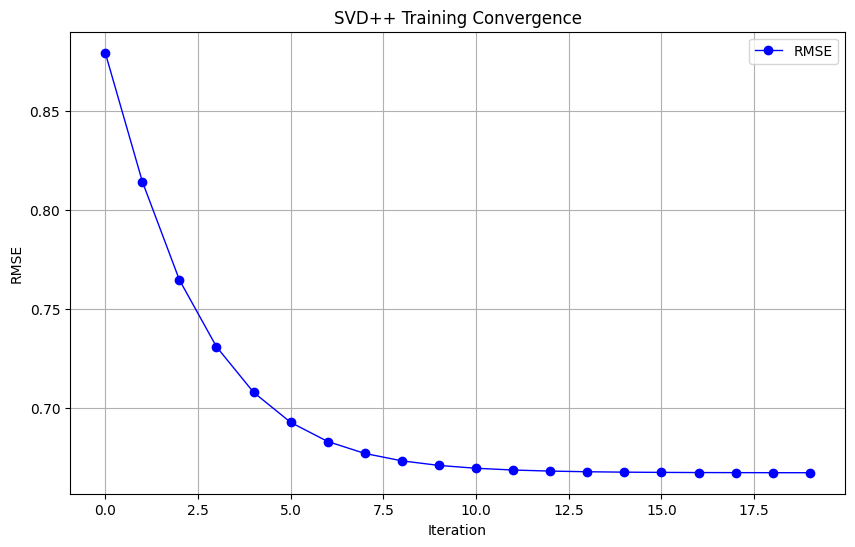

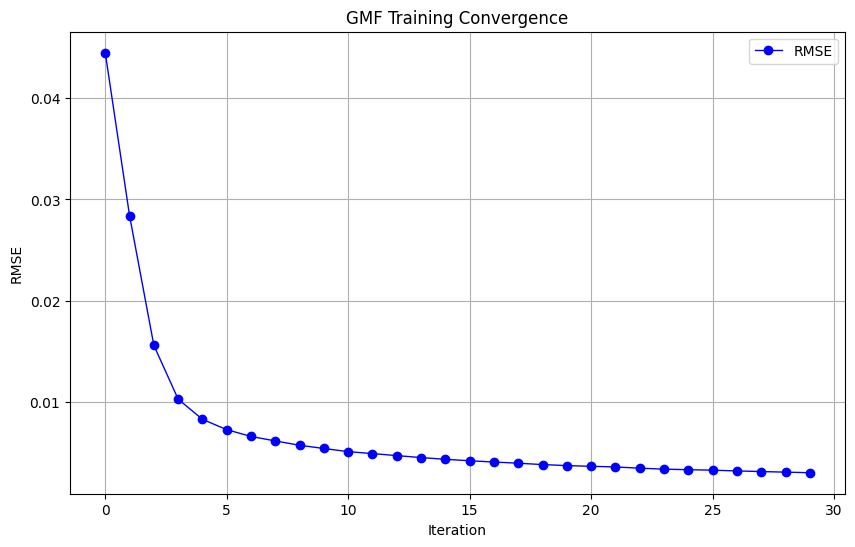

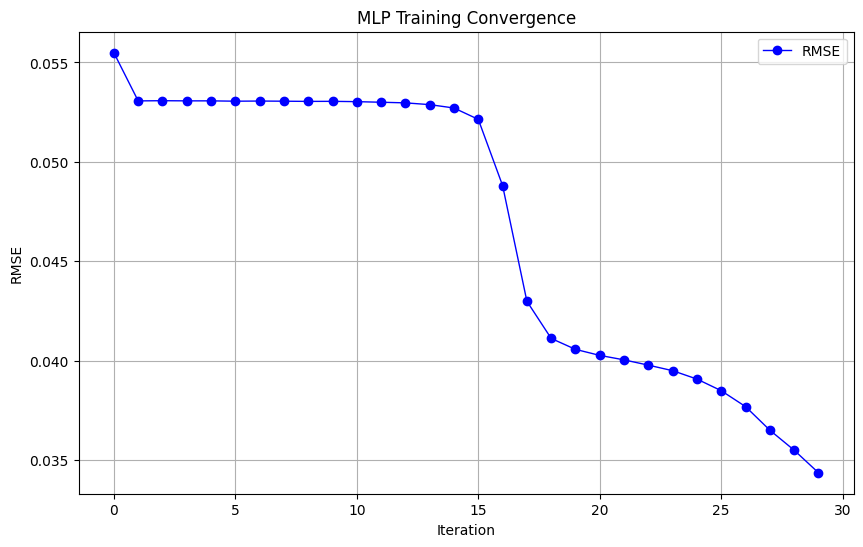

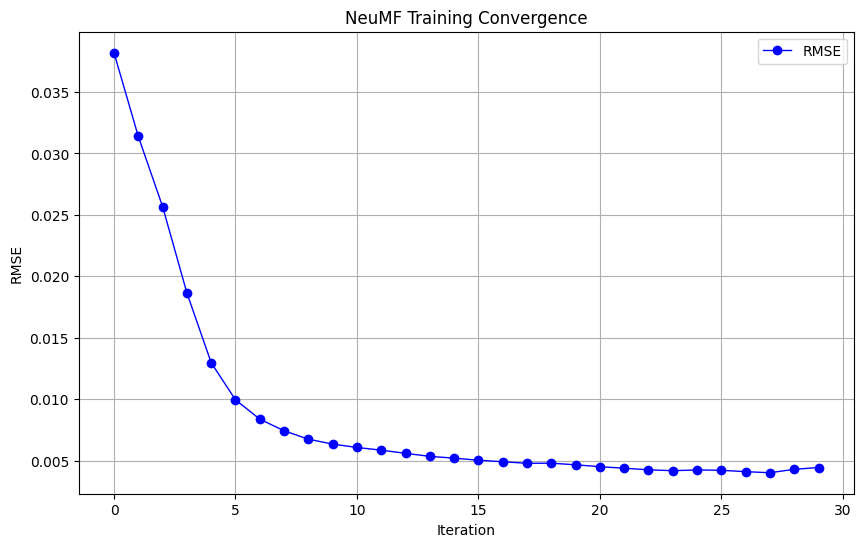

In [27]:
plot_errors(svdpp['errors'], 'SVD++ Training Convergence')
plot_errors(gmf_error, 'GMF Training Convergence')
plot_errors(mlp_error, 'MLP Training Convergence')
plot_errors(neumf_error, 'NeuMF Training Convergence')

It seems those nn based models learn faster and with less overfitting.